In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (12, 6)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

# from https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib?rq=1
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
train_df = pd.read_csv("data/train.csv")

### Lets preprocess the text

In [3]:
# removing punctuation
train_df['text'] = train_df['text'].str.replace('[^\w\s]','')
# Lower case
train_df['text'] = train_df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# remove stop words
# train_df['text'] = train_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# remove links
train_df['text'] = train_df['text'].str.replace('http\S+|www.\S+', '', case=False)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [4]:
NULL_PLACEHOLDER = 'NULL_PLACEHOLDER_A1234131'.lower()
train_df['keyword'] = train_df['keyword'].fillna(NULL_PLACEHOLDER).apply(lambda x :x.lower()).replace(NULL_PLACEHOLDER,np.nan)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.corpus import stopwords
stop = stopwords.words('english')

def standarize(df):
    # Spelling corrections
    #  df['n_text'] = df['text'].apply(lambda x: str(TextBlob(x).correct())) ### TOO SLOW
    # Steamming
    #  st = PorterStemmer()
    #  df['n_text'] = df['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    # Lemmatization
    df['n_text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df

def joinTerms(df):
    grouped = df.groupby('n_text')['frequency'].agg('sum')
    grouped = grouped.reset_index()
    return grouped

def raw_ngrams(serie, low=2, high=6):
    # from: https://stackoverflow.com/questions/36572221/how-to-find-ngram-frequency-of-a-column-in-a-pandas-dataframe
    word_vectorizer = CountVectorizer(ngram_range=(low, high), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(serie)
    frequencies = sum(sparse_matrix).toarray()[0]
    data = {
        'text': word_vectorizer.get_feature_names(),
        'frequency': frequencies
    }
    df = pd.DataFrame(data)
    return df

# filter those terms with more thatn 50% of stopwords
def filter_n_gram_by_stopwords(df):
    df['stop_words'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['sw_percentage'] = df['stop_words']/df['word_count']
    return df[df['sw_percentage']< 0.5]
        
def n_grams_standarized(series, low=2, high=6):
    ngrams = raw_ngrams(series, low, high)
    ngrams_no_spw = filter_n_gram_by_stopwords(ngrams)
    standarized = standarize(ngrams_no_spw)
    return joinTerms(standarized).sort_values(by=['frequency'], ascending=False)

In [6]:
top_words = n_grams_standarized(train_df['text'], 1, 1)
top_words

,n_text,frequency
5801,fire,350
8805,like,347
7486,im,299
1242,amp,298
6346,get,255
...,...,...
6861,hasil,1
6863,hassanrouhani,1
6864,hassle,1
6865,hastle,1


In [7]:
top_words.describe()

,frequency
count,"16,666.00"
mean,4.25
std,12.29
min,1.00
25%,1.00
50%,1.00
75%,2.00
max,350.00


### Lets try to use it tf idf for getting the most important words, but instead of using each tweet as a documents lets have two documents for each value of target and then lets get the most relevant words for each one

In [8]:
# lets use tf idf to get the relevant words in for each document
# based on: https://sigdelta.com/blog/text-analysis-in-pandas/
train_df['words'] = train_df['text'].str.strip().str.split('[\W_]+')
train_df.head()

,id,keyword,location,text,target,words
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala..."


In [9]:
rows = list()
for row in train_df[['target', 'words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((r.target, word))

words = pd.DataFrame(rows, columns=['target', 'word'])
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

,target,word
0,1,our
1,1,deeds
2,1,are
3,1,the
4,1,reason


In [10]:
counts = words.groupby('target')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts.head()

n_w
target word      
0      the   1906
       a     1254
       to    1188
       i     1078
       and    917

In [11]:
word_sum = counts.groupby(level=0)\
    .sum()\
    .rename(columns={'n_w': 'n_d'})
tf = counts.join(word_sum)
tf['tf'] = tf.n_w/tf.n_d

c_d = words.target.nunique()

In [12]:
idf = words.groupby('word')\
    .target\
    .nunique()\
    .to_frame()\
    .rename(columns={'target':'i_d'})\
    .sort_values('i_d')


idf['idf'] = np.log(c_d/idf.i_d.values)
tf_idf = tf.join(idf)
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
tf_idf.reset_index()
tf_idf

n_w    n_d                   tf  i_d                  idf  \
target word                                                                 
0      the     1906  60749                 0.03    2                 0.00   
       a       1254  60749                 0.02    2                 0.00   
       to      1188  60749                 0.02    2                 0.00   
       i       1078  60749                 0.02    2                 0.00   
       and      917  60749                 0.02    2                 0.00   
...             ...    ...                  ...  ...                  ...   
1      ûïthe      1  46388                 0.00    2                 0.00   
       ûïyou      1  46388                 0.00    2                 0.00   
       ûòthe      1  46388                 0.00    1                 0.69   
       ûóher      1  46388                 0.00    1                 0.69   
       ûókody     1  46388                 0.00    1                 0.69   

                            tf_idf  
target word                         
0      the                    0.00  
       a                      0.00  
       to                     0.00  
       i                      0.00  
       and                    0.00  
...                            ...  
1      ûïthe                  0.00  
       ûïyou                  0.00  
       ûòthe                  0.00  
       ûóher                  0.00  
       ûókody                 0.00  

[22265 rows x 6 columns]

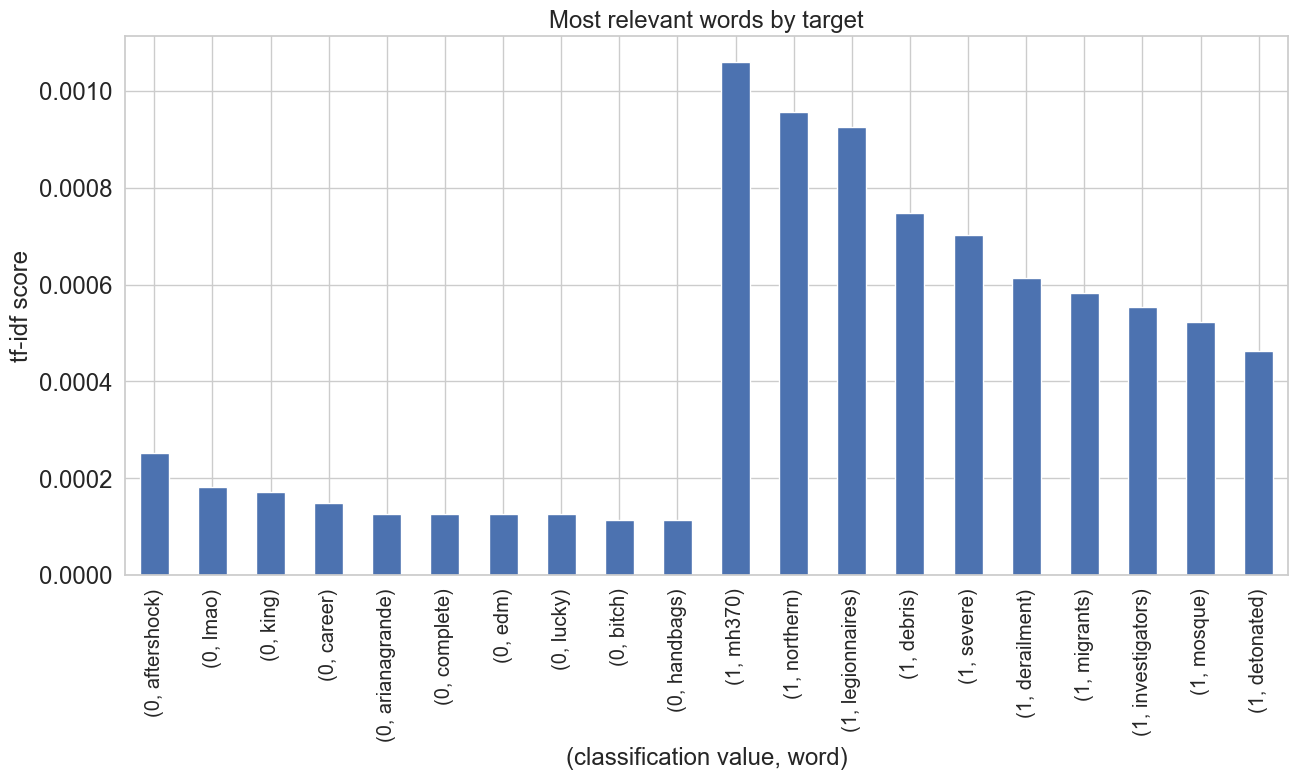

In [13]:
def pretty_plot_top_n(series, top_n=10, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    plot = r.plot.bar(title='Most relevant words by target')
    plot.set_xlabel('(classification value, word)')
    plot.set_ylabel('tf-idf score')
#     plot.get_figure().save_fig('exports/tf-idf words.pns')
    return

idf = words.groupby('word')\
    .target\
    .nunique()\
    .to_frame()\
    .rename(columns={'target':'i_d'})\
    .sort_values('i_d')

idf['idf'] = np.log(c_d/idf.i_d.values)
tf_idf = tf.join(idf)
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
r = pretty_plot_top_n(tf_idf['tf_idf'])

### Lets look at n-grams default value for n in [2, 6] 

In [14]:
top_n_grams = n_grams_standarized(train_df['text'])
top_n_grams[:10]

,n_text,frequency
162444,suicide bomber,60
104253,look like,49
25707,body bag,48
29274,burning building,46
201241,youtube video,43
102453,liked youtube video,42
102452,liked youtube,42
120650,northern california,41
42767,cross body,39
125621,oil spill,39


In [15]:
top_n_grams.describe()

,frequency
count,"202,355.00"
mean,1.24
std,1.36
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,60.00


In [16]:
n_grams_non_disaster = n_grams_standarized(train_df[train_df['target'] == 0]['text'])
n_grams_non_disaster[:10]

,n_text,frequency
14332,body bag,46
23605,cross body,38
116173,youtube video,36
58426,liked youtube video,35
58425,liked youtube,35
59672,look like,32
34792,feel like,25
38865,full reû_,25
14394,body bagging,23
23618,cross body bag,22


In [17]:
n_grams_disaster = n_grams_standarized(train_df[train_df['target'] == 1]['text'])
n_grams_disaster[:10]

,n_text,frequency
72985,suicide bomber,60
54153,northern california,41
56609,oil spill,38
14853,california wildfire,36
73045,suicide bombing,34
2243,70 year,30
50862,more home razed,29
37166,home razed by,29
37165,home razed,29
54175,northern california wildfire,29


In [18]:
train_df[train_df['text'].str.contains('homes razed by northern california wildfire')]['text']
top_n_grams[top_n_grams['n_text'].str.contains('suicid')][:10]

,n_text,frequency
162444,suicide bomber,60
162504,suicide bombing,34
162503,suicide bomber who detonated bomb in,28
162501,suicide bomber who detonated,28
162500,suicide bomber who,28
162502,suicide bomber who detonated bomb,28
133736,pkk suicide,28
133737,pkk suicide bomber,28
133738,pkk suicide bomber who,28
133739,pkk suicide bomber who detonated,28


As we can see a lot of the n-grams with n > 3 are way too specific so we will discard them.
We will work also with 2-grams and 3-grams with a frequency > 10

### Bigrams and trigrams

In [19]:
n_grams_non_disaster = n_grams_standarized(train_df[train_df['target'] == 0]['text'], 2, 3)
n_grams_non_disaster = n_grams_non_disaster[n_grams_non_disaster['frequency'] > 10]
n_grams_non_disaster

,n_text,frequency
6056,body bag,46
10045,cross body,38
48738,youtube video,36
24854,liked youtube,35
24855,liked youtube video,35
...,...,...
28569,natural disaster,11
45347,video to youtube,11
1349,added video,11
1350,added video to,11


In [20]:
n_grams_disaster = n_grams_standarized(train_df[train_df['target'] == 1]['text'], 2, 3)
n_grams_disaster = n_grams_disaster[n_grams_disaster['frequency'] > 10]

Number of non disaster terms only:

In [21]:
terms_non_disaster = list(set(n_grams_non_disaster['n_text']) - set(n_grams_disaster['n_text']))
len(terms_non_disaster)

115

Number of disaster terms only:

In [22]:
terms_disaster = list(set(n_grams_disaster['n_text']) - set(n_grams_non_disaster['n_text']))
len(terms_disaster)

298

Lets take a look at repeats

In [23]:
train_df[train_df['text'].str.contains('homes razed by northern california wildfire')]['text']

5579    the latest more homes razed by northern califo...
5581    the latest more homes razed by northern califo...
5582    the latest more homes razed by northern califo...
5583    the latest more homes razed by northern califo...
5584    the latest more homes razed by northern califo...
5585     the latest more homes razed by northern calif...
5586    news the latest more homes razed by northern c...
5587    the latest more homes razed by northern califo...
5588    the latest more homes razed by northern califo...
5589    the latest more homes razed by northern califo...
5590    the latest more homes razed by northern califo...
5591    the latest more homes razed by northern califo...
5593    the latest more homes razed by northern califo...
5594    the latest more homes razed by northern califo...
5595    the latest more homes razed by northern califo...
5597    the latest more homes razed by northern califo...
5598    the latest more homes razed by northern califo...
5599    the la

There are multiple tweets describing the same event

In [24]:
repeats = train_df.groupby(['target','text']).agg({ 'id':'count'})
repeats = repeats.reset_index()
repeats.rename(columns={'id':'count'}, inplace=True)
repeats = repeats[repeats['count'] > 2]
repeats[:10]

,target,text,count
38,0,13 reasons why we love women in the military l...,4
54,0,2pcs 18w cree led work light offroad lamp car ...,3
61,0,320 ir icemoon aftershock djicemoon dubstep t...,7
241,0,ambulance sprinter automatic frontline vehicle...,4
441,0,beware of your temper and a loose tongue these...,3
501,0,bluedio turbine hurricane h bluetooth 41 wirel...,3
702,0,coastal german shepherd rescue oc shared a lin...,3
741,0,crackdown 3 destruction restricted to multipla...,3
901,0,dk eyewitness travel guide denmark travel guid...,3
909,0,do you feel engulfed with low selfimage take t...,3


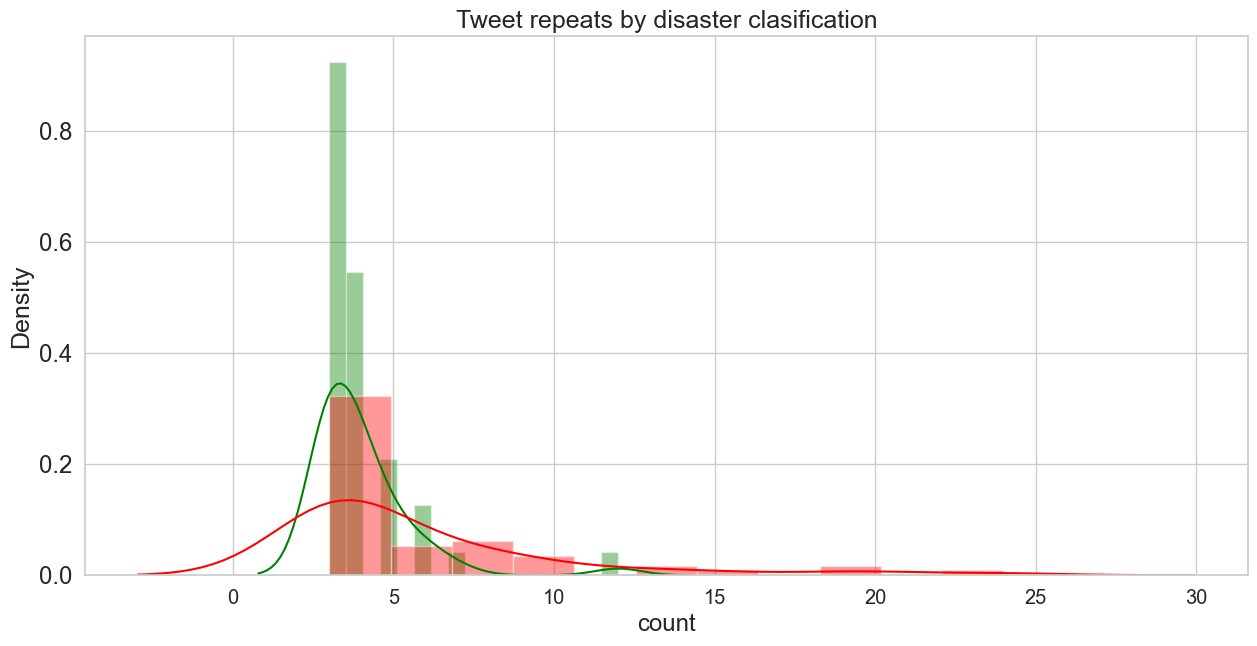

In [25]:
plot = sns.distplot(repeats[repeats['target']==0]["count"], color="green", label='Fake disasters', hist=True)
plot = sns.distplot(repeats[repeats['target']==1]["count"], color="red", label='Real disasters', hist=True)

plot.set_title("Tweet repeats by disaster clasification", fontsize=18)
plot.set_ylabel("Density", fontsize=18)
plot.figure.savefig('exports/tweet repeats.png', dpi=100)

In [26]:
repeats['count'].sum()

528

In [27]:
(repeats[repeats['target'] == 0]['count'].sum(), repeats[repeats['target'] == 1]['count'].sum())

(180, 348)

In [28]:
(repeats[repeats['target'] == 0]['count'].mean(), repeats[repeats['target'] == 0]['count'].std())

(4.0, 1.5954480704349312)

In [29]:
(repeats[repeats['target'] == 1]['count'].mean(), repeats[repeats['target'] == 1]['count'].std())

(5.8, 4.542828208901721)

Lets see if those repeats also share keywords

In [30]:
repeats_text_kw = train_df.groupby(['target','text', 'keyword']).agg({ 'id':'count'})
repeats_text_kw = repeats_text_kw.reset_index()
repeats_text_kw.rename(columns={'id':'count'}, inplace=True)
repeats_text_kw = repeats_text_kw[repeats_text_kw['count'] > 2]
repeats_text_kw['count']

38       4
54       3
61       7
241      4
442      3
        ..
6818    24
6855     3
6927     3
6929    20
6976     3
Name: count, Length: 104, dtype: int64

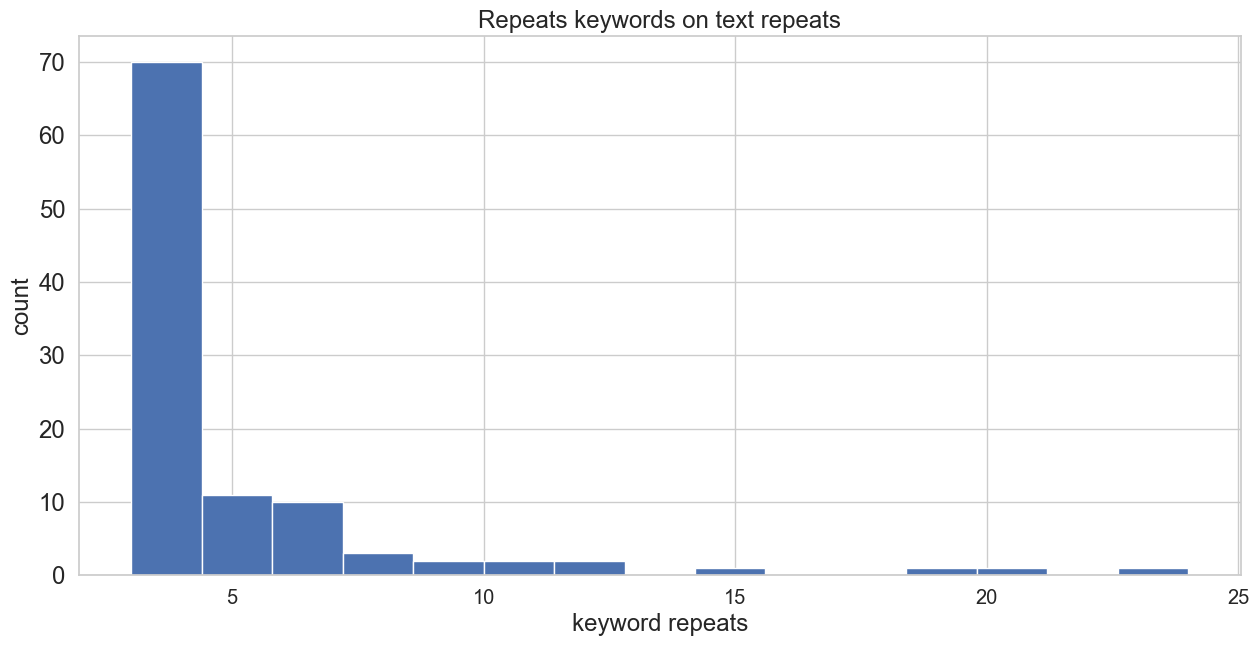

In [31]:
plot = repeats_text_kw['count'].hist(bins=15)
plot.set_title('Repeats keywords on text repeats')
plot.set_xlabel('keyword repeats')
plot.set_ylabel('count')
plot.figure.savefig("exports/Keyword repeats on text repeats.png")